In [ ]:
%pip -q uninstall -y transformers tokenizers datasets accelerate huggingface_hub protobuf numpy pyarrow
%pip -q install \
  "protobuf<5.0.0" \
  "transformers==4.44.2" \
  "datasets==2.20.0" \
  "accelerate==0.34.2" \
  "tokenizers>=0.19.1" \
  "huggingface_hub>=0.24" \
  "safetensors>=0.4" \
  "sentencepiece>=0.1.99" \
  "numpy==1.26.4" \
  "pyarrow==15.0.2"

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 76.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 101.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 52.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 81.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 15.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [ ]:
import os
os.kill(os.getpid(), 9)

In [3]:
import transformers, datasets, accelerate, google.protobuf as gp, numpy, pyarrow
import torch, sys, platform
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("accelerate:", accelerate.__version__)
print("protobuf:", gp.__version__)
print("numpy:", numpy.__version__)
print("pyarrow:", pyarrow.__version__)
print("python:", sys.version.split()[0], "| torch:", torch.__version__, "| cuda:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

transformers: 4.44.2
datasets: 2.20.0
accelerate: 0.34.2
protobuf: 4.25.8
numpy: 1.26.4
pyarrow: 15.0.2
python: 3.11.13 | torch: 2.6.0+cu124 | cuda: True
gpu: Tesla T4


In [ ]:
import os, json, numpy as np, torch
from datasets import load_from_disk
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)

BASE_DIR = "/kaggle/working"
LANG_TAG = "pt"
SAVE_LANG_DIR = f"{BASE_DIR}/{LANG_TAG}"
TOK_DIR = f"{SAVE_LANG_DIR}/tok_xlmr_256"

SEED = 42
torch.manual_seed(SEED); 
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

2025-12-03 19:17:16.730040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764789437.132336     120 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764789437.291404     120 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
tok = load_from_disk(TOK_DIR)
with open(f"{SAVE_LANG_DIR}/label2id.json","r",encoding="utf-8") as f: label2id = json.load(f)
with open(f"{SAVE_LANG_DIR}/id2label.json","r",encoding="utf-8") as f: id2label = json.load(f)
num_labels = len(label2id)

MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_bal_counts = np.bincount(tok["train"]["labels"], minlength=num_labels)

def class_balanced_weights(counts, beta=0.99):
    counts = np.asarray(counts, dtype=float)
    eff_num = (1.0 - np.power(beta, counts)) / (1.0 - beta)
    w = 1.0 / np.maximum(eff_num, 1e-9)
    return (w / w.sum()) * len(w)

USE_LIGHT_WEIGHTS = False
if USE_LIGHT_WEIGHTS:
    w = class_balanced_weights(train_bal_counts, beta=0.99)
    class_weights = torch.tensor(w, dtype=torch.float)
    print("Light class weights:", w)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    return {"accuracy": acc, "precision_macro": prec, "recall_macro": rec, "f1_macro": f1}

from transformers import Trainer
import torch.nn as nn

class WeightedCELossTrainer(Trainer):
    def __init__(self, class_weights: torch.Tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
USE_BF16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
USE_FP16 = torch.cuda.is_available() and not USE_BF16

OUTPUT_DIR = f"{SAVE_LANG_DIR}/xlmr_{LANG_TAG}_sentiment"

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=SEED,
    report_to="none",
    fp16=USE_FP16,
    bf16=USE_BF16,
)

if USE_LIGHT_WEIGHTS:
    trainer = WeightedCELossTrainer(
        class_weights=class_weights,
        model=model,
        args=args,
        train_dataset=tok["train"],
        eval_dataset=tok["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )
else:
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tok["train"],
        eval_dataset=tok["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

trainer.train()

BEST_DIR = f"{SAVE_LANG_DIR}/xlmr_{LANG_TAG}_best"
model_to_save = trainer.model
model_to_save.save_pretrained(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)
with open(f"{BEST_DIR}/label2id.json","w",encoding="utf-8") as f: json.dump(label2id,f,ensure_ascii=False,indent=2)
with open(f"{BEST_DIR}/id2label.json","w",encoding="utf-8") as f: json.dump(id2label,f,ensure_ascii=False,indent=2)
print("Saved best model to:", BEST_DIR)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.690500,0.469518,0.795691,0.591062,0.815817,0.650852
2,0.376100,0.711830,0.730545,0.575747,0.856114,0.620267
3,0.268200,0.459311,0.849683,0.665652,0.878585,0.731443


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Saved best model to: /kaggle/working/pt/xlmr_pt_best


In [ ]:
import shutil, os
MODEL_DIR = f"/kaggle/working/{LANG_TAG}/xlmr_{LANG_TAG}_best"
ZIP_PATH  = f"/kaggle/working/xlmr_{LANG_TAG}_best.zip"

shutil.make_archive(ZIP_PATH.replace(".zip", ""), 'zip', MODEL_DIR)
print(f"Model zipped successfully:\n{ZIP_PATH}")

In [ ]:
import numpy as np
import json
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

eval_res = trainer.evaluate(eval_dataset=tok["test"])
print("Raw eval from Trainer:")
print(json.dumps(eval_res, indent=2))

preds = trainer.predict(tok["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
metrics = {
    "accuracy": acc,
    "precision_macro": prec,
    "recall_macro": rec,
    "f1_macro": f1,
}
print("\nComputed metrics:")
print(json.dumps(metrics, indent=2))

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Raw eval from Trainer:
{
  "eval_loss": 0.4593108594417572,
  "eval_accuracy": 0.8496831432192649,
  "eval_precision_macro": 0.6656517296477172,
  "eval_recall_macro": 0.8785849136428987,
  "eval_f1_macro": 0.7314432674987627,
  "eval_runtime": 40.8764,
  "eval_samples_per_second": 96.511,
  "eval_steps_per_second": 3.034,
  "epoch": 3.0
}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Computed metrics:
{
  "accuracy": 0.8496831432192649,
  "precision_macro": 0.6656517296477172,
  "recall_macro": 0.8785849136428987,
  "f1_macro": 0.7314432674987627
}


In [ ]:
keys = list(id2label.keys())
first_key = keys[0]

if isinstance(first_key, str):
    target_names = [id2label[str(i)] for i in range(num_labels)]
else:
    target_names = [id2label[i] for i in range(num_labels)]

print("target_names:", target_names)

print("\nClassification report:")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=target_names,
    )
)

target_names: ['negative', 'neutral', 'positive']

Classification report:
              precision    recall  f1-score   support

    negative       0.42      0.90      0.57       315
     neutral       0.98      0.84      0.91      3373
    positive       0.59      0.90      0.71       257

    accuracy                           0.85      3945
   macro avg       0.67      0.88      0.73      3945
weighted avg       0.91      0.85      0.87      3945



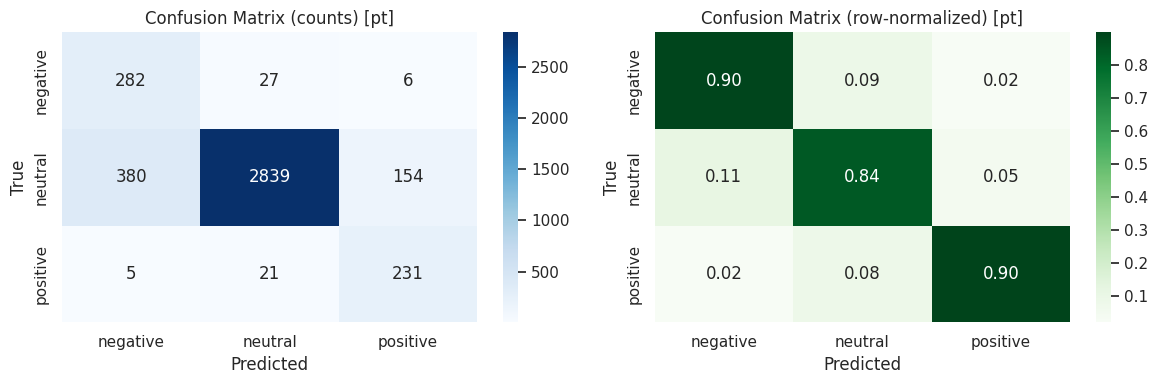

Saved figure to: /kaggle/working/pt/figs/cm_pt.png
Saved metrics to: /kaggle/working/pt/metrics_pt.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sns.set_theme()

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax[0],
    xticklabels=target_names,
    yticklabels=target_names,
)
ax[0].set_title(f"Confusion Matrix (counts) [{LANG_TAG}]")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    ax=ax[1],
    xticklabels=target_names,
    yticklabels=target_names,
)
ax[1].set_title(f"Confusion Matrix (row-normalized) [{LANG_TAG}]")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")

plt.tight_layout()

figs_dir = os.path.join(SAVE_LANG_DIR, "figs")
os.makedirs(figs_dir, exist_ok=True)

fig_path = os.path.join(figs_dir, f"cm_{LANG_TAG}.png")
plt.savefig(fig_path, dpi=180)
plt.show()

metrics_df = pd.DataFrame([metrics])
metrics_path = os.path.join(SAVE_LANG_DIR, f"metrics_{LANG_TAG}.csv")
metrics_df.to_csv(metrics_path, index=False)

print("Saved figure to:", fig_path)
print("Saved metrics to:", metrics_path)